In [0]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout, Concatenate, Add
from keras  import layers
from keras.models import Model
from keras import regularizers 
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import pandas as pd

import scipy.io as io

Using TensorFlow backend.


In [0]:
# from tensorflow.python.client import device_lib
# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()


In [0]:
M=16

Tx=2
Rx=2

Tx_NN=256
Rx_NN=2048


In [0]:
np.arange(0,20,3)

array([ 0,  3,  6,  9, 12, 15, 18])

In [0]:
#Build encoder

M_input=Input(shape=(M,), name='M')
V_input = Input(shape=(8,), name='V')
Ch_input =Input(shape=(8,), name='CH')
Sigma = Input(shape=(1,), name='SIGMA')
U_input = Input(shape=(8,), name='U')

Tx_input = keras.layers.Concatenate(axis=-1, name='sig2Tx')([M_input, V_input])

layer = Dense(units =Tx_NN, activation='relu')(Tx_input)
layer = Dense(units =Tx_NN, activation='relu')(layer)

Tx_output = Dense(units =2*Tx, activation='linear')(layer)
Tx_output =  Lambda(lambda x: x / K.sqrt(2*K.mean(K.square(x))), name='Power_Constrain')(Tx_output)

to_mimo = keras.layers.Concatenate(axis=-1, name='sig2Channel')([Tx_output, Ch_input, Sigma])


def mimo_channel(in_know):    
    sig = in_know[:, 0:4]
    ch = in_know[:, 4:12]
    sigma = in_know[0, 12]
    
    sig_real = tf.reshape(sig[:, 0:2], (-1, 2,1))
    sig_imag = tf.reshape(sig[:, 2:4], (-1, 2,1))
    
    ch_real = tf.reshape(ch[:, 0:4], (-1,2,2))
    ch_imag = tf.reshape(ch[:, 4:8], (-1,2,2))
    
    rx_real = tf.matmul(ch_real, sig_real) - tf.matmul(ch_imag, sig_imag) 
    rx_imag = tf.matmul(ch_real, sig_imag) + tf.matmul(ch_imag, sig_real)
    rx = tf.reshape(tf.concat([rx_real, rx_imag], axis=1), (-1, 4))
    rx = rx + tf.random.normal(mean=0, stddev=sigma, shape=tf.shape(rx))
    return rx
Rx= Lambda(mimo_channel, name='Channel_Layer')(to_mimo)


# Build Decoder

# Rx_input = keras.layers.Concatenate(axis=-1, name='sig2Rx')([Rx, U_input])
# layer = Dense(units=Rx_NN, activation='relu')(Rx_input)
layer = Dense(units=Rx_NN, activation='relu')(Rx)
layer = Dense(units=Rx_NN, activation='relu')(layer)
layer = Dense(units=Rx_NN, activation='relu')(layer)
Rx_output = Dense(units=M, activation='softmax')(layer)

auto_encoder = Model(inputs=[M_input, Ch_input, U_input,Sigma, V_input], outputs= Rx_output)

opt = Adam(lr=0.001)
auto_encoder.compile(optimizer=opt, loss='categorical_crossentropy')


In [0]:
M_input3=Input(shape=(M,), name='M')
Ch_input3 =Input(shape=(8,), name='CH')
Sigma3 = Input(shape=(1,), name='SIGMA')

Tx_input3 = keras.layers.Concatenate(axis=-1, name='sig2Tx')([M_input3, Ch_input3])

layer3 = Dense(units =Tx_NN, activation='relu')(Tx_input3)
layer3 = Dense(units =Tx_NN, activation='relu')(layer3)

Tx_output3 = Dense(units =2*Tx, activation='linear')(layer3)
Tx_output3 =  Lambda(lambda x: x / K.sqrt(2*K.mean(K.square(x))), name='Power_Constrain')(Tx_output3)

to_mimo3 = keras.layers.Concatenate(axis=-1, name='sig2Channel')([Tx_output3, Ch_input3, Sigma3])


Rx3= Lambda(mimo_channel, name='Channel_Layer')(to_mimo3)


# Build Decoder

Rx_input3 = keras.layers.Concatenate(axis=-1, name='sig2Rx')([Rx3, Ch_input3])
Rx_input3 = BatchNormalization()(Rx_input3)
# Rx_input3 = BatchNormalization()(Rx3)
layer3 = Dense(units=Rx_NN, activation='relu')(Rx_input3)
layer3 = BatchNormalization()(layer3)
layer3 = Dense(units=Rx_NN, activation='relu')(layer3)
layer3 = BatchNormalization()(layer3)
layer3 = Dense(units=Rx_NN, activation='relu')(layer3)
layer3 = BatchNormalization()(layer3)
layer3 = Dense(units=Rx_NN, activation='relu')(layer3)
layer3 = BatchNormalization()(layer3)
Rx_output3 = Dense(units=M, activation='softmax')(layer3)

auto_encoder3 = Model(inputs=[M_input3, Ch_input3, Sigma3], outputs= Rx_output3)

opt3 = Adam(lr=0.001)
#configures the model for training
auto_encoder3.compile(optimizer=opt3, loss='categorical_crossentropy')


batch=6400 * 400

train_messages = np.arange(M)
train_messages = np.tile(train_messages, batch)
train_labels = to_categorical(train_messages)

channel = (np.random.normal(size=[batch * 16, 2, 2]) + 1j*np.random.normal(size=[batch * 16, 2, 2]))/np.sqrt(2)
ch = np.reshape(channel, (-1, 4))
ch = np.concatenate([ch.real, ch.imag], axis=-1)

T_SNR = 15
snr_linear = np.power(10, T_SNR/10)
sigma_train = np.sqrt(0.5/snr_linear)
sigma_train = sigma_train * np.ones((ch.shape[0],1))

history = auto_encoder3.fit(x=[train_labels, ch,sigma_train], y=train_labels, batch_size=2048, verbose=1, epochs=15)










Epoch 1/15
40960000/40960000 [==============================] - 751s 18us/step - loss: 0.0152
Epoch 2/15
40960000/40960000 [==============================] - 749s 18us/step - loss: 0.0033
Epoch 3/15
40960000/40960000 [==============================] - 751s 18us/step - loss: 0.0026
Epoch 4/15
40960000/40960000 [==============================] - 750s 18us/step - loss: 0.0022
Epoch 5/15
40960000/40960000 [==============================] - 752s 18us/step - loss: 0.0021
Epoch 6/15
40960000/40960000 [==============================] - 750s 18us/step - loss: 0.0019
Epoch 7/15
40960000/40960000 [==============================] - 745s 18us/step - loss: 0.0018
Epoch 8/15
40960000/40960000 [==============================] - 743s 18us/step - loss: 0.0018
Epoch 9/15
40960000/40960000 [==============================] - 739s 18us/step - loss: 0.0017
Epoch 10/15
40960000/40960000 [==============================] - 739s 18us/step - loss: 0.0017
Epoch 11/15
40960000/40960000 [============================

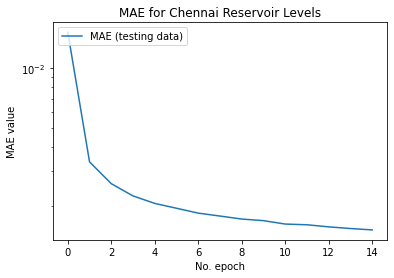

In [0]:
plt.semilogy(history.history['loss'], label='MAE (testing data)')

plt.title('MAE for Chennai Reservoir Levels')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [0]:
auto_encoder3.save('path_to_my_model.h5')

In [0]:
# new_model = keras.models.load_model('path_to_my_model.h5')

In [0]:
# SNR_array = np.arange(0, 22)
# SER3 = []
# for snr in SNR_array:
#     snr_linear = np.power(10, snr/10)
#     sigma_train = np.sqrt(0.5/snr_linear)

#     batch=6400
#     train_messages = np.arange(M)
#     train_messages = np.tile(train_messages, batch)
#     train_labels = to_categorical(train_messages)

#     channel = (np.random.normal(size=[batch * 16, 2, 2]) + 1j*np.random.normal(size=[batch * 16, 2, 2]))/np.sqrt(2)
#     ch = np.reshape(channel, (-1, 4))
#     ch = np.concatenate([ch.real, ch.imag], axis=-1)

    
#     sigma_train = sigma_train * np.ones((ch.shape[0],1))

#     prob_distribution = auto_encoder3.predict(x=[train_labels, ch, sigma_train], batch_size=1024*10)
   
#     classification = np.argmax(prob_distribution, axis=1)
#     correct = np.equal(classification , train_messages)
#     ser = 1- np.mean(correct)
#     SER3 = np.append(SER3, ser)

In [0]:
SNR_array = np.arange(0, 25,2)
SER3 = []
for snr in SNR_array:
    ser_flag = 0
    for temp in np.arange(20):
        ser = 0
        snr_linear = np.power(10, snr/10)
        sigma_train = np.sqrt(0.5/snr_linear)
        frames = 15
        batch=64000
        train_messages = np.arange(M)
        train_messages = np.tile(train_messages, batch)
        train_labels = to_categorical(train_messages)

        channel = (np.random.normal(size=[frames * 16, 2, 2]) + 1j*np.random.normal(size=[frames * 16, 2, 2]))/np.sqrt(2)
        channel = np.tile(channel, (batch,1,1))
        ch = np.reshape(channel, (-1, 4))
        ch = np.concatenate([ch.real, ch.imag], axis=-1)

        
        sigma_train = sigma_train * np.ones((ch.shape[0],1))

        prob_distribution = auto_encoder3.predict(x=[train_labels, ch, sigma_train], batch_size=1024*10)
      
        classification = np.argmax(prob_distribution, axis=1)
        correct = np.equal(classification , train_messages)
        ser = 1- np.mean(correct)
        ser_flag = ser_flag + ser
        
    SER3 = np.append(SER3, ser_flag/20)
    # print(SER3)

[6.29755420e-01 5.19213770e-01 3.82001270e-01 2.36681250e-01
 1.28499121e-01 4.73665039e-02 1.48571777e-02 3.05795898e-03
 2.15478516e-04 1.93847656e-05 4.88281250e-08 0.00000000e+00
 0.00000000e+00]


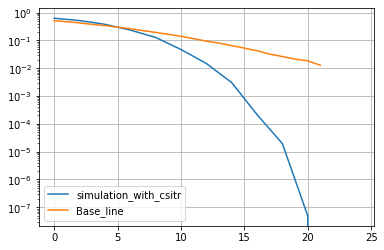

In [0]:
print(SER3)
plt.figure()
SNR = np.arange(0, 22)

base_line = np.array([0.51663, 0.47059, 0.42939 ,0.3782,  0.34221, 0.30084 ,0.26423, 0.22573 ,0.1949,
 0.16623, 0.14124, 0.1161 , 0.09486 ,0.07995, 0.06518 ,0.05308, 0.04256, 0.03233,
 0.02639 ,0.02132, 0.0185 , 0.01276])
csitr, base = plt.semilogy(SNR_array, SER3, SNR, base_line)
plt.grid(True)
plt.legend([ csitr, base], ['simulation_with_csitr', 'Base_line'])

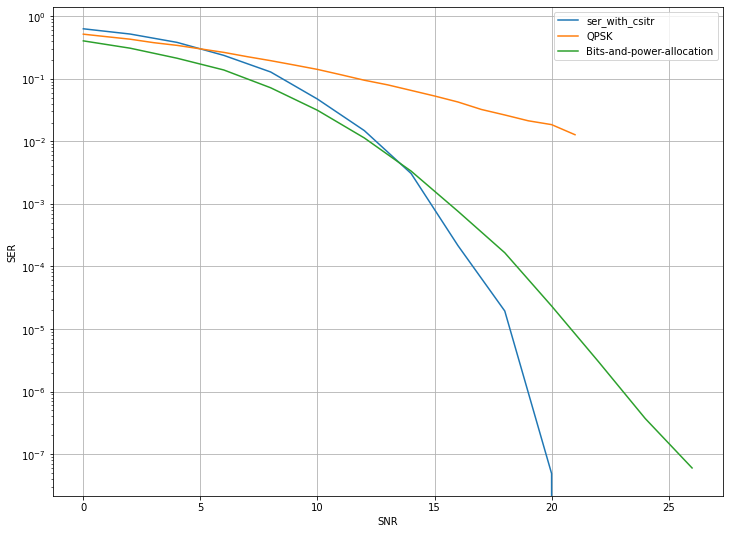

In [0]:
from google.colab import files
plt.figure(figsize=(12,9))
SNR = np.arange(0, 22)

base_line = np.array([0.51663, 0.47059, 0.42939 ,0.3782,  0.34221, 0.30084 ,0.26423, 0.22573 ,0.1949,
 0.16623, 0.14124, 0.1161 , 0.09486 ,0.07995, 0.06518 ,0.05308, 0.04256, 0.03233,
 0.02639 ,0.02132, 0.0185 , 0.01276])

SNR2 = np.array([0 ,  0.457574905606751,   0.969100130080564 ,  1.549019599857432,   2.218487496163564,
   3.010299956639812,   3.979400086720376,   5.228787452803376  , 6.989700043360188  ,10.000000000000000,
  10.969100130080564 , 12.218487496163563 , 13.979400086720377,  15.228787452803376 , 16.989700043360187,
  20.000000000000000])

base_line2 = np.array([4.037860e-01, 3.083340e-01, 2.132100e-01, 1.382575e-01, 7.183750e-02,
  3.136500e-02, 1.133280e-02 ,3.339900e-03 ,7.619000e-04 ,1.655000e-04,
  2.330000e-05 ,3.010000e-06, 3.700000e-07, 6.000000e-08])

csitr, base, base2 = plt.semilogy( SNR_array, SER3, SNR, base_line,np.arange(0,27,2), base_line2)
plt.grid(True)
plt.legend([ csitr, base, base2], ['ser_with_csitr', 'QPSK','Bits-and-power-allocation'])
plt.xlabel('SNR')
plt.ylabel('SER')
plt.savefig('svd_ser.pdf')
# files.download('svd_ser.pdf') 



In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       drive = GoogleDrive(gauth)

SyntaxError: ignored

In [0]:
auto_encoder3.save('model.h5')
model_file = drive.CreateFile({'title' : 'model.h5'})                       model_file.SetContentFile('model.h5')                       model_file.Upload()